---

# Representation Learning and Generative Learning Using Autoencoders and GANs

---

## Reducing Dimensions with a linear Autoencoder

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import matplotlib as plt

In [3]:
import tensorflow as tf

In [4]:
from tensorflow import keras

In [5]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


---

Build 3D dataset:

In [11]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

In [12]:
X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

---

Now let's build the Autoencoder

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
# This is kind of hidde layer

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])

In [15]:
# This is kind of output layer

decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])

In [16]:
autoencoder = keras.models.Sequential([encoder, decoder])

In [17]:
# By deafault activation function is 0

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

In [18]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Train on 60 samples
Epoch 1/20
60/60 [==============================] - 1s 21ms/sample - loss: 0.3064
Epoch 2/20
60/60 [==============================] - 0s 83us/sample - loss: 0.3797
Epoch 3/20
60/60 [==============================] - 0s 66us/sample - loss: 0.1454
Epoch 4/20
60/60 [==============================] - 0s 67us/sample - loss: 0.0872
Epoch 5/20
60/60 [==============================] - 0s 66us/sample - loss: 0.0658
Epoch 6/20
60/60 [==============================] - 0s 83us/sample - loss: 0.0464
Epoch 7/20
60/60 [==============================] - 0s 50us/sample - loss: 0.0356
Epoch 8/20
60/60 [==============================] - 0s 67us/sample - loss: 0.0238
Epoch 9/20
60/60 [==============================] - 0s 66us/sample - loss: 0.0225
Epoch 10/20
60/60 [==============================] - 0s 84us/sample - loss: 0.0093
Epoch 11/20
60/60 [==============================] - 0s 33us/sample - loss: 0.0068
Epoch 12/20
60/60 [==============================] - 0s 33us/sample - loss: 

In [19]:
# Predicting with encoder

codings = encoder.predict(X_train)

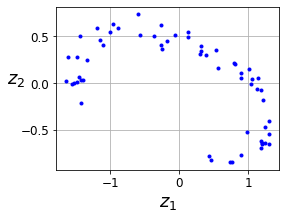

In [20]:
# 2D representation of the data....

fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

---

# Stacked Autoencoders

Let's use MNIST:

In [21]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

---

# Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [22]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [23]:
tf.random.set_seed(42)
np.random.seed(42)

In [24]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])

In [25]:
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [26]:
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

In [27]:
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])

In [28]:
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 4s 74us/sample - loss: 0.3390 - rounded_accuracy: 0.8860 - val_loss: 0.3111 - val_rounded_accuracy: 0.9129
Epoch 2/20
55000/55000 [==============================] - 3s 61us/sample - loss: 0.3059 - rounded_accuracy: 0.9149 - val_loss: 0.3048 - val_rounded_accuracy: 0.9201
Epoch 3/20
55000/55000 [==============================] - 3s 58us/sample - loss: 0.2989 - rounded_accuracy: 0.9212 - val_loss: 0.3033 - val_rounded_accuracy: 0.9120
Epoch 4/20
55000/55000 [==============================] - 3s 59us/sample - loss: 0.2950 - rounded_accuracy: 0.9246 - val_loss: 0.2944 - val_rounded_accuracy: 0.9277
Epoch 5/20
55000/55000 [==============================] - 3s 61us/sample - loss: 0.2924 - rounded_accuracy: 0.9268 - val_loss: 0.2923 - val_rounded_accuracy: 0.9280
Epoch 6/20
55000/55000 [==============================] - 3s 59us/sample - loss: 0.2908 - rounded_accuracy: 0.9280 - val_loss:

---

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [34]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [32]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

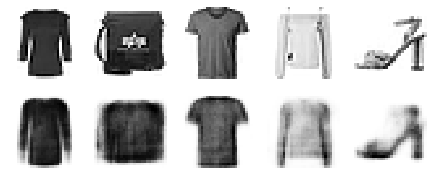

In [30]:
show_reconstructions(stacked_ae)

---

# Visualizing the Fashion MNIST Dataset

In [31]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

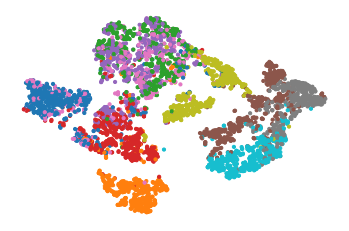

In [32]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

---

Let's make this diagram a bit prettier:

Saving figure fashion_mnist_visualization_plot


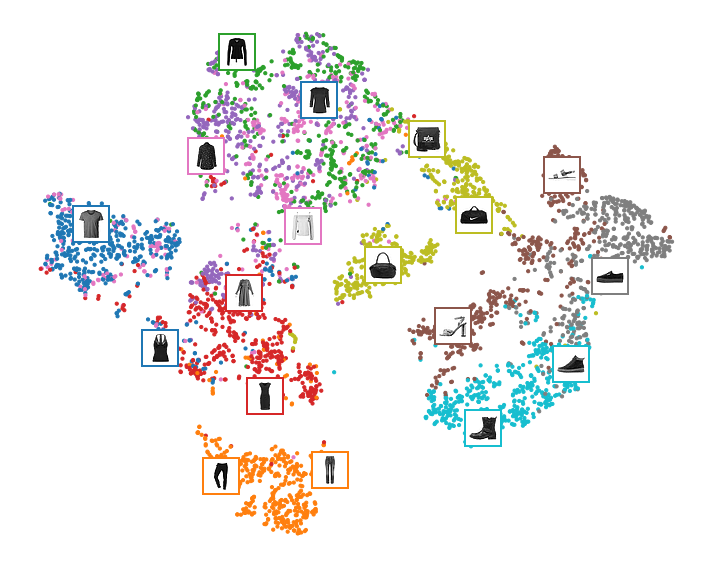

In [33]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

---

# Training one Autoencoder at a Time

In [34]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(lr=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(lr=0.05),
    output_activation="selu")

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 64us/sample - loss: 0.3446 - rounded_accuracy: 0.8873 - val_loss: 0.3123 - val_rounded_accuracy: 0.9148
Epoch 2/10
55000/55000 [==============================] - 3s 53us/sample - loss: 0.3040 - rounded_accuracy: 0.9202 - val_loss: 0.3008 - val_rounded_accuracy: 0.9248
Epoch 3/10
55000/55000 [==============================] - 3s 51us/sample - loss: 0.2951 - rounded_accuracy: 0.9284 - val_loss: 0.2936 - val_rounded_accuracy: 0.9314
Epoch 4/10
55000/55000 [==============================] - 3s 50us/sample - loss: 0.2893 - rounded_accuracy: 0.9340 - val_loss: 0.2889 - val_rounded_accuracy: 0.9357
Epoch 5/10
55000/55000 [==============================] - 3s 49us/sample - loss: 0.2855 - rounded_accuracy: 0.9376 - val_loss: 0.2859 - val_rounded_accuracy: 0.9387
Epoch 6/10
55000/55000 [==============================] - 3s 49us/sample - loss: 0.2829 - rounded_accuracy: 0.9401 - val_loss:

In [36]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

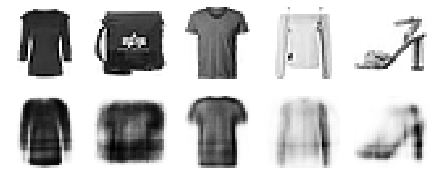

In [37]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [38]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 65us/sample - loss: 0.2847 - rounded_accuracy: 0.9366 - val_loss: 0.2863 - val_rounded_accuracy: 0.9366
Epoch 2/10
55000/55000 [==============================] - 3s 60us/sample - loss: 0.2844 - rounded_accuracy: 0.9369 - val_loss: 0.2861 - val_rounded_accuracy: 0.9369
Epoch 3/10
55000/55000 [==============================] - 3s 57us/sample - loss: 0.2842 - rounded_accuracy: 0.9371 - val_loss: 0.2859 - val_rounded_accuracy: 0.9370
Epoch 4/10
55000/55000 [==============================] - 3s 61us/sample - loss: 0.2840 - rounded_accuracy: 0.9373 - val_loss: 0.2858 - val_rounded_accuracy: 0.9370
Epoch 5/10
55000/55000 [==============================] - 3s 61us/sample - loss: 0.2839 - rounded_accuracy: 0.9374 - val_loss: 0.2857 - val_rounded_accuracy: 0.9373
Epoch 6/10
55000/55000 [==============================] - 3s 60us/sample - loss: 0.2838 - rounded_accuracy: 0.9375 - val_loss:

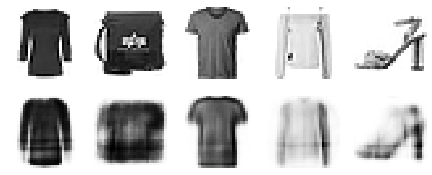

In [39]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

---

# Recurrent Auto Encoder

In [40]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [41]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 62s 1ms/sample - loss: 0.5106 - rounded_accuracy: 0.7595 - val_loss: 0.4448 - val_rounded_accuracy: 0.8217
Epoch 2/10
55000/55000 [==============================] - 64s 1ms/sample - loss: 0.4087 - rounded_accuracy: 0.8403 - val_loss: 0.3913 - val_rounded_accuracy: 0.8485
Epoch 3/10
55000/55000 [==============================] - 66s 1ms/sample - loss: 0.3704 - rounded_accuracy: 0.8673 - val_loss: 0.3618 - val_rounded_accuracy: 0.8735
Epoch 4/10
55000/55000 [==============================] - 66s 1ms/sample - loss: 0.3549 - rounded_accuracy: 0.8774 - val_loss: 0.3671 - val_rounded_accuracy: 0.8669
Epoch 5/10
55000/55000 [==============================] - 65s 1ms/sample - loss: 0.3429 - rounded_accuracy: 0.8853 - val_loss: 0.3387 - val_rounded_accuracy: 0.8896
Epoch 6/10
55000/55000 [==============================] - 63s 1ms/sample - loss: 0.3350 - rounded_accuracy: 0.8907 - val_loss:

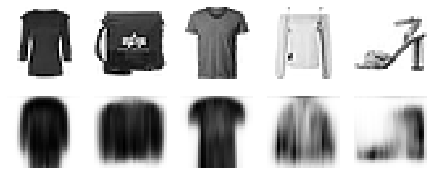

In [42]:
show_reconstructions(recurrent_ae)
plt.show()

---

# Sparse AutoEncoders

Let's build a simple stacked autoencoder, so we can compare it to the sparse autoencoders we will build. This time we will use the sigmoid activation function for the coding layer, to ensure that the coding values range from 0 to 1:

In [43]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.4332 - rounded_accuracy: 0.7944 - val_loss: 0.3777 - val_rounded_accuracy: 0.8503
Epoch 2/10
55000/55000 [==============================] - 4s 65us/sample - loss: 0.3614 - rounded_accuracy: 0.8667 - val_loss: 0.3511 - val_rounded_accuracy: 0.8786
Epoch 3/10
55000/55000 [==============================] - 4s 65us/sample - loss: 0.3403 - rounded_accuracy: 0.8860 - val_loss: 0.3360 - val_rounded_accuracy: 0.8896
Epoch 4/10
55000/55000 [==============================] - 4s 65us/sample - loss: 0.3280 - rounded_accuracy: 0.8962 - val_loss: 0.3256 - val_rounded_accuracy: 0.9006
Epoch 5/10
55000/55000 [==============================] - 4s 65us/sample - loss: 0.3213 - rounded_accuracy: 0.9012 - val_loss: 0.3215 - val_rounded_accuracy: 0.9016
Epoch 6/10
55000/55000 [==============================] - 4s 67us/sample - loss: 0.3178 - rounded_accuracy: 0.9037 - val_loss:

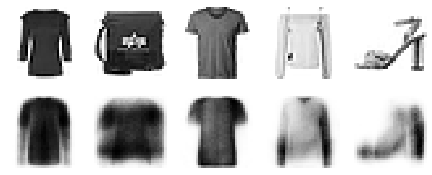

In [44]:
show_reconstructions(simple_ae)
plt.show()

---

Now let's add  ℓ1  regularization to the coding layer:

In [29]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.4311 - rounded_accuracy: 0.8128 - val_loss: 0.3809 - val_rounded_accuracy: 0.8564
Epoch 2/10
55000/55000 [==============================] - 4s 64us/sample - loss: 0.3691 - rounded_accuracy: 0.8687 - val_loss: 0.3639 - val_rounded_accuracy: 0.8750
Epoch 3/10
55000/55000 [==============================] - 4s 66us/sample - loss: 0.3546 - rounded_accuracy: 0.8799 - val_loss: 0.3504 - val_rounded_accuracy: 0.8859
Epoch 4/10
55000/55000 [==============================] - 4s 65us/sample - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3437 - val_rounded_accuracy: 0.8917
Epoch 5/10
55000/55000 [==============================] - 4s 66us/sample - loss: 0.3373 - rounded_accuracy: 0.8922 - val_loss: 0.3361 - val_rounded_accuracy: 0.8946
Epoch 6/10
55000/55000 [==============================] - 4s 66us/sample - loss: 0.3319 - rounded_accuracy: 0.8971 - val_loss:

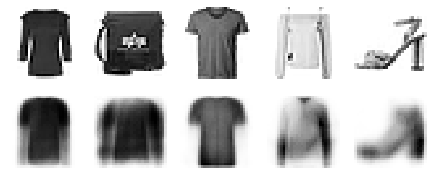

In [35]:
show_reconstructions(sparse_l1_ae)

---

# Generative Adversial Networks

In [45]:
# It's better to run below code on Google Colab because, it is time and resource consuming code. 

np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [46]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [47]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [48]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

In [50]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Epoch 1/1


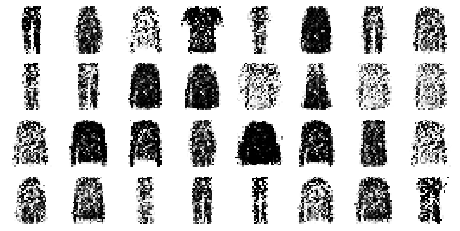

In [51]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Saving figure gan_generated_images_plot


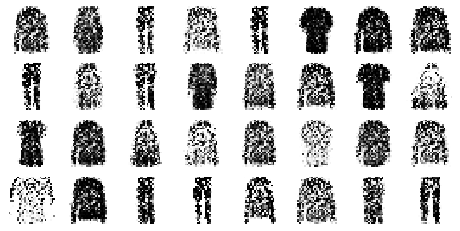

In [52]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

Epoch 1/50


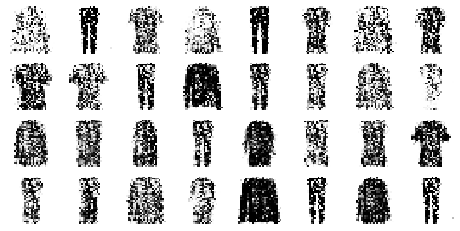

Epoch 2/50


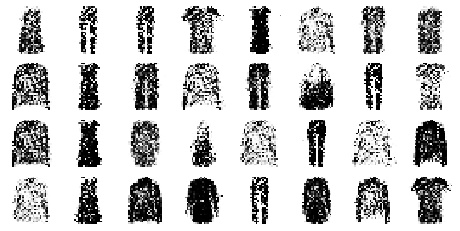

Epoch 3/50


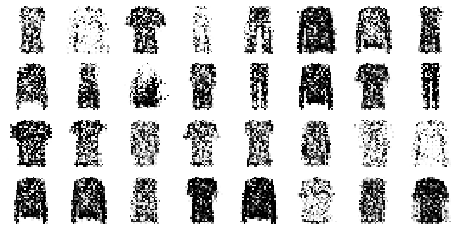

Epoch 4/50


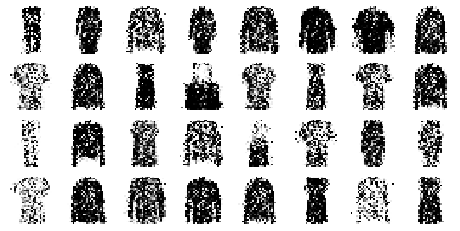

Epoch 5/50


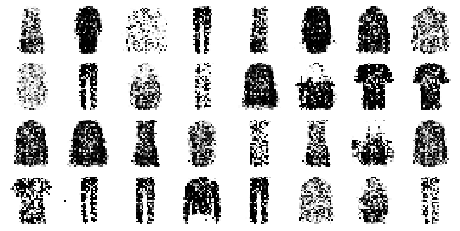

Epoch 6/50


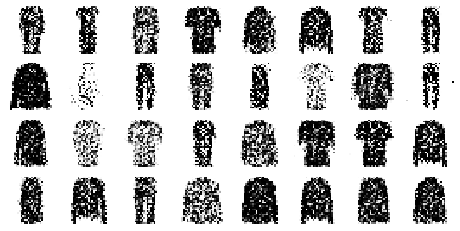

Epoch 7/50


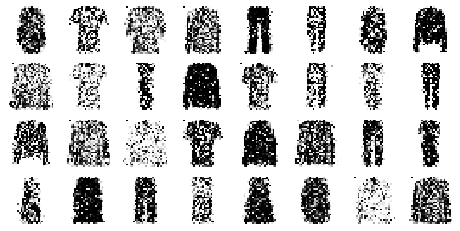

Epoch 8/50


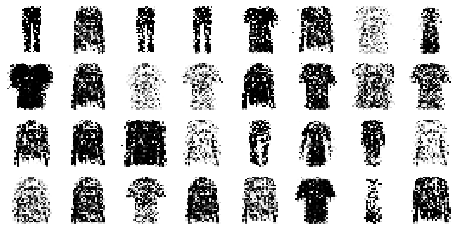

Epoch 9/50


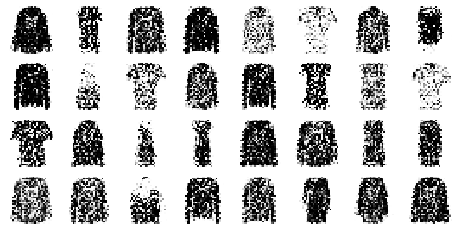

Epoch 10/50


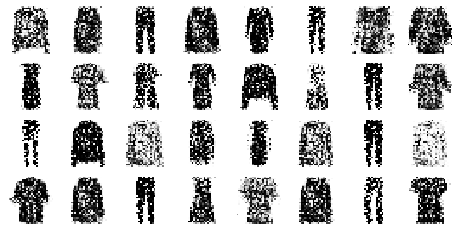

Epoch 11/50


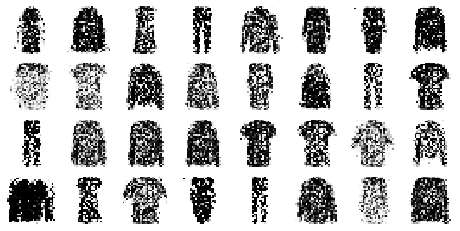

Epoch 12/50


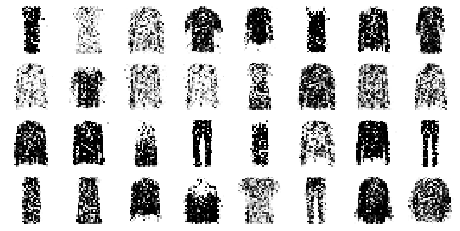

Epoch 13/50


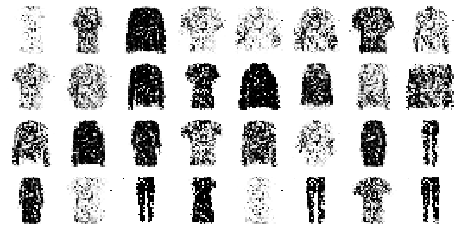

Epoch 14/50


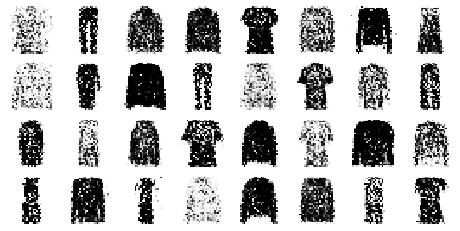

Epoch 15/50


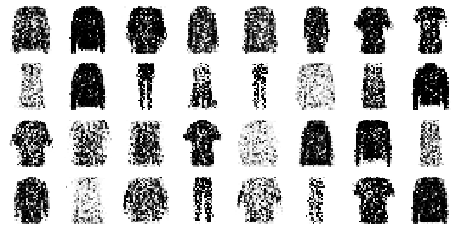

Epoch 16/50


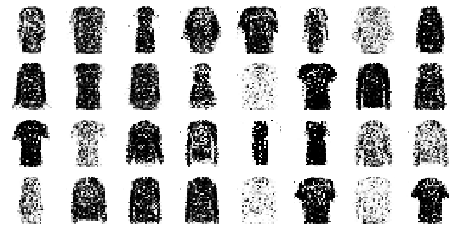

Epoch 17/50


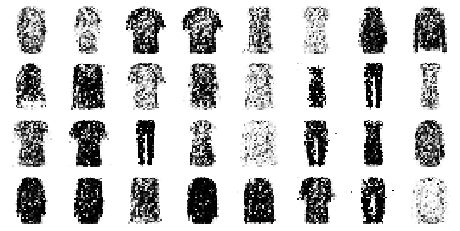

Epoch 18/50


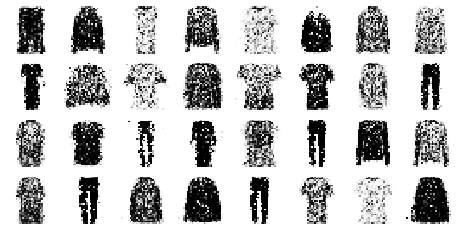

Epoch 19/50


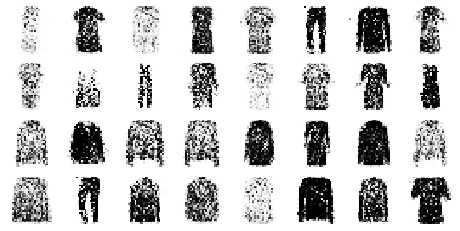

Epoch 20/50


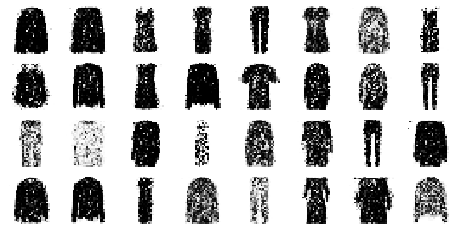

Epoch 21/50


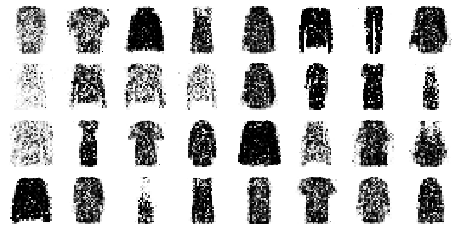

Epoch 22/50


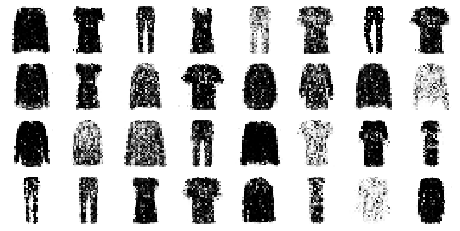

Epoch 23/50


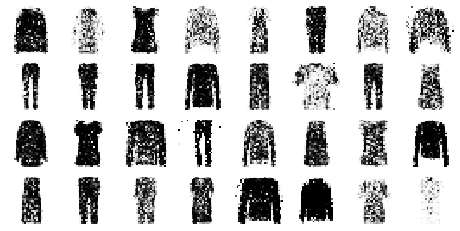

Epoch 24/50


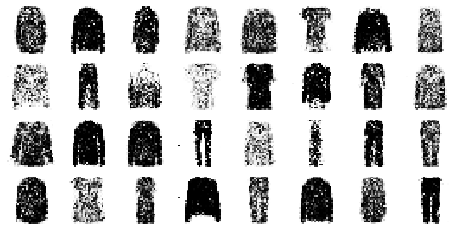

Epoch 25/50


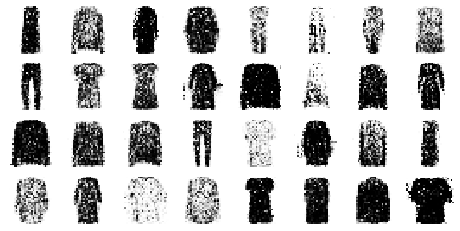

Epoch 26/50


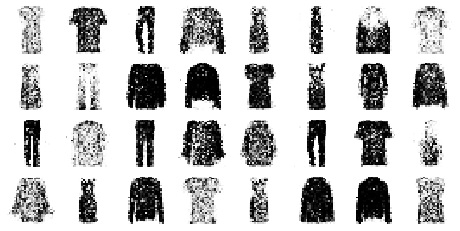

Epoch 27/50


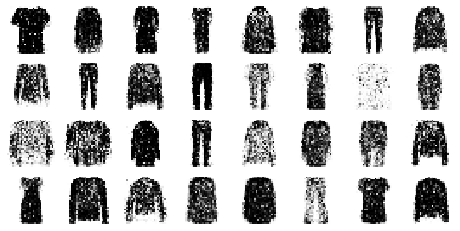

Epoch 28/50


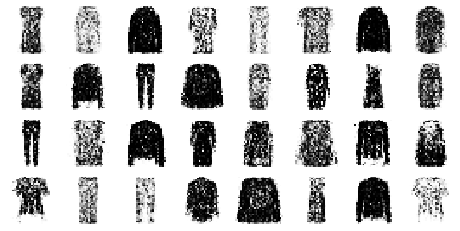

Epoch 29/50


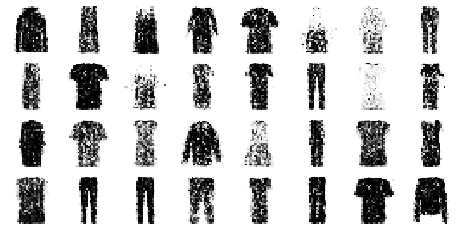

Epoch 30/50


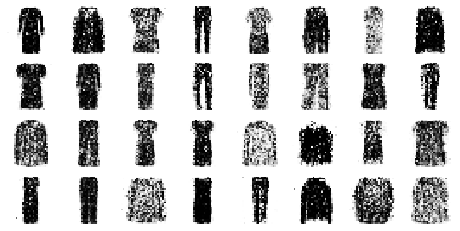

Epoch 31/50


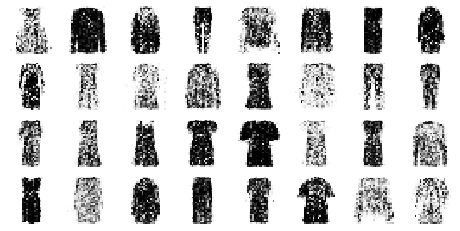

Epoch 32/50


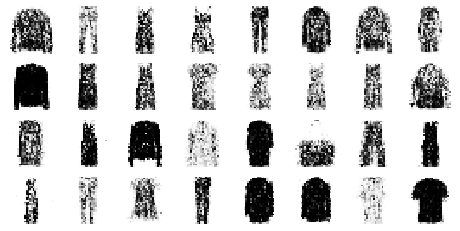

Epoch 33/50


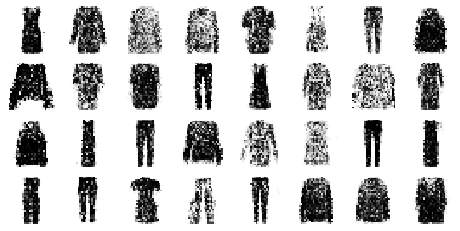

Epoch 34/50


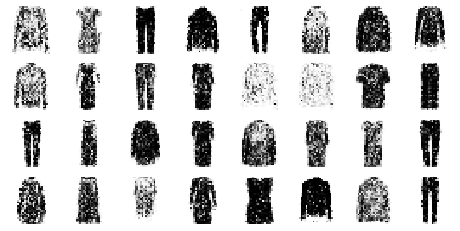

Epoch 35/50


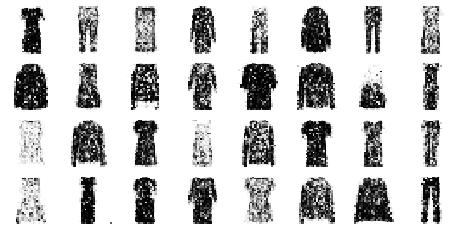

Epoch 36/50


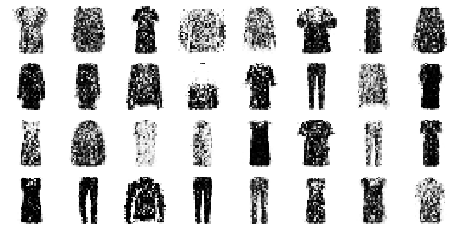

Epoch 37/50


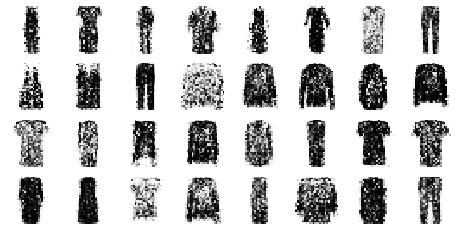

Epoch 38/50


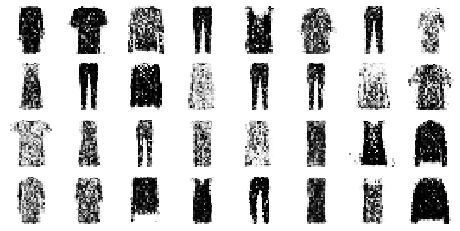

Epoch 39/50


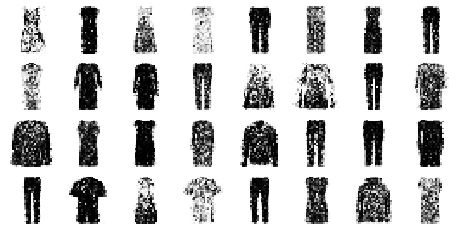

Epoch 40/50


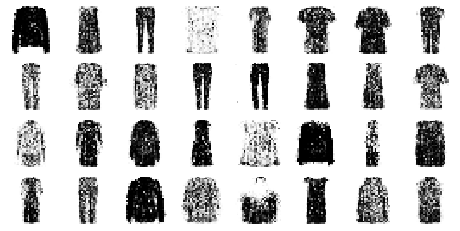

Epoch 41/50


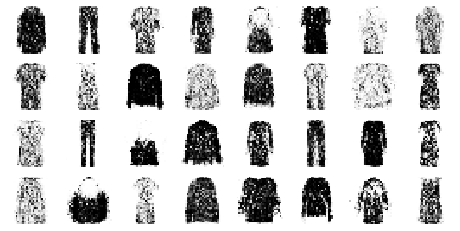

Epoch 42/50


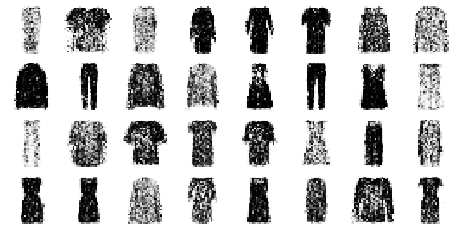

Epoch 43/50


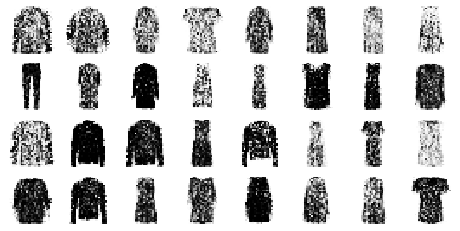

Epoch 44/50


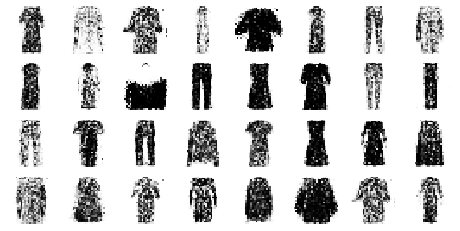

Epoch 45/50


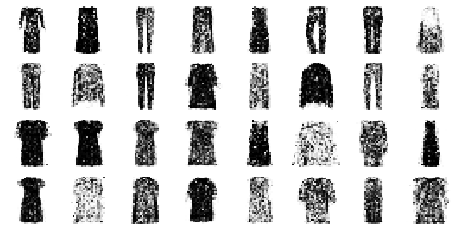

Epoch 46/50


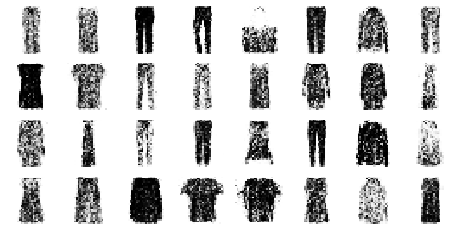

Epoch 47/50


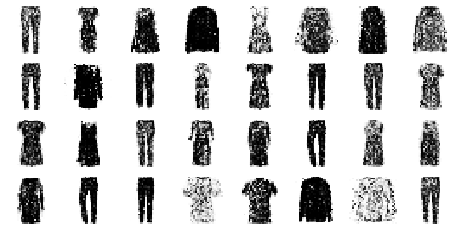

Epoch 48/50


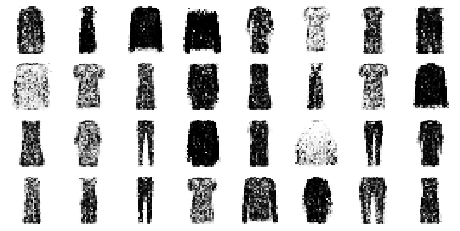

Epoch 49/50


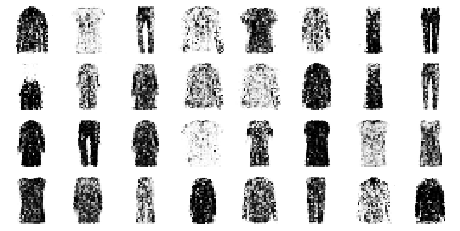

Epoch 50/50


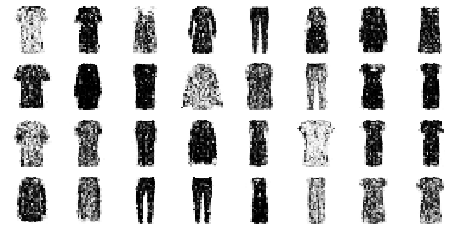

In [53]:
train_gan(gan, dataset, batch_size, codings_size)

---

# Deep Convolutional GAN

In [54]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [55]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [56]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [57]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50


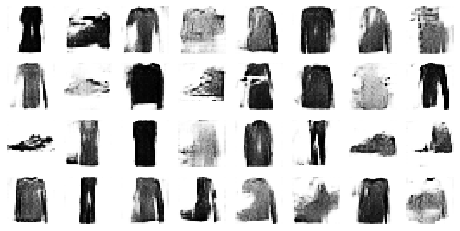

Epoch 2/50


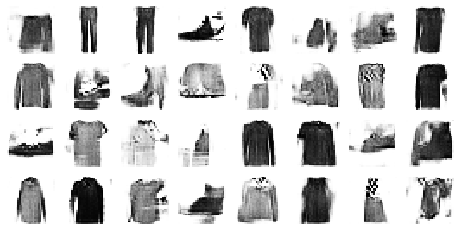

Epoch 3/50


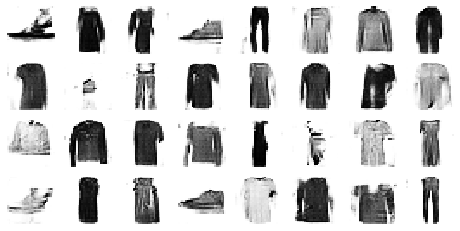

Epoch 4/50


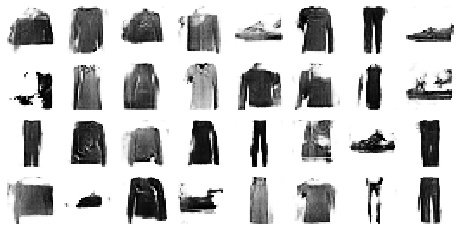

Epoch 5/50


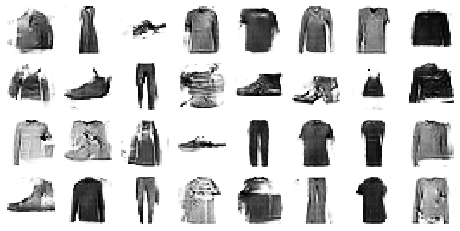

Epoch 6/50


In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
